Those based in Toronto should be all too familiar with the TTC (Toronto Transit Commission), the city's public transit system. Most of us likely have a love-hate relationship with this essential but sometimes unreliable service. The topic of delays on the TTC is as popular of a small talk topic as the weather. As someone who's lived in Toronto for more than a decade, the subway certainly *feels* slower, but I have not kept tracked of it all. Ever since I discovered that the City of Toronto publishes data on subway delays through its Open Data Portal, I have wanted to analyze it. As a regular commuter (I unfortunately have to commute 1.5h one way to get to work), I would be very interested in seeing whether there are any time patterns that I could take advantage of to shorten my own trips. 

# TTC Subway Delay Data Prep

## Download Data

The data is available on https://open.toronto.ca/ in xlsx format by month. To download the data, I used my `pyopendatato` package. The raw data required some cleaning up, as shown below. 

In [1]:
import os
import re
import json
import calendar
import requests
import numpy as np
import pandas as pd
from pyopendatato.ckanTO import ckanTO as ckanTO

In [2]:
dirs = ['raw_data', 'processed_data', 'helper_data', 'weather_data']

for dir_i in dirs:
    if not os.path.exists(dir_i):
        os.makedirs(dir_i)

In [3]:
ct = ckanTO()
ct.search_packages(query = "subway")

,id,title,topics,excerpt,formats,num_resources,refresh_rate,last_refreshed,notes
0,4eb6a6af-7199-4822-a89e-3e3ce5106d14,TTC Ridership - Subway-Scarborough RT Station ...,Transportation,This dataset lists typical subway station/SRT ...,XLSX,5,Annually,2017-12-31T00:00:00.000000,\r\n \r\nThis dataset lists typical subway ...
1,c01c6d71-de1f-493d-91ba-364ce64884ac,TTC Subway Shapefiles,None,This dataset contains separate shape files for...,SHP,1,As available,2018-04-30T00:00:00.000000,\r\nThis dataset contains separate shape files...
2,996cfe8d-fb35-40ce-b569-698d51fc683b,TTC Subway Delay Data,Transportation,TTC Subway Delay Data,XLSX,33,Monthly,2019-11-08T15:59:02.717220,TTC Subway & SRT Train Service Delay Data\r\n\r\n


In [4]:
data_list = ct.get_package_metadata("996cfe8d-fb35-40ce-b569-698d51fc683b")['resources']

df = pd.DataFrame()
for data in data_list:
    if data["name"] not in ["ttc-subway-delay-codes", "ttc-subway-delay-readme"]:
        df = df.append(ct.get_resource(data["id"]))

df.reset_index(drop = True, inplace = True)
df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle
0,2014-01-01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111
1,2014-01-01,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001
2,2014-01-01,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,NaN,YU,0
3,2014-01-01,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116
4,2014-01-01,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386


In [5]:
df.to_csv('raw_data/ttc_delay_raw_data.csv', index = False)

Here, each row represents a separate delay event. The date, time, day of week, station(s) affected, direction of train, subway line and train # are all recorded, in addition to the duration of delay (`Min Delay`) and the gap between the next train (`Min Gap`). `Code` represents cause for the delay, but first we need to map it to the text description. The legend is provided within one of the spreadsheets, but that also requires some clean-up first (the data is arranged in two panes by Subway versus SRT delay codes, but they can really be represented within the same table). 

## Map Delay Code to Delay Description

In [6]:
for data in data_list:
    if data["name"] == "ttc-subway-delay-codes":
        mapping = ct.get_resource(data["id"])

mapping.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,SUB RMENU CODE,CODE DESCRIPTION,NaN,NaN,SRT RMENU CODE,CODE DESCRIPTION
1,NaN,1.0,EUAC,Air Conditioning,NaN,1.0,ERAC,Air Conditioning
2,NaN,2.0,EUAL,Alternating Current,NaN,2.0,ERBO,Body
3,NaN,3.0,EUATC,ATC RC&S Equipment,NaN,3.0,ERCD,Consequential Delay (2nd Delay Same Fault)
4,NaN,4.0,EUBK,Brakes,NaN,4.0,ERCO,Couplers


In [7]:
mapping = mapping.drop(columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 4', 'Unnamed: 5'], index = 0)
mapping.columns = ['code_sub', 'desc_sub', 'code_srt', 'desc_srt']

mapping = pd.concat([
    mapping[['code_sub', 'desc_sub']].rename(columns = {'code_sub': 'Code', 'desc_sub': 'Desc'}), 
    mapping[['code_srt', 'desc_srt']].rename(columns = {'code_srt': 'Code', 'desc_srt': 'Desc'})
])

mapping.Code = mapping.Code.str.strip()
mapping = mapping.dropna().reset_index(drop = True)

mapping.head()

,Code,Desc
0,EUAC,Air Conditioning
1,EUAL,Alternating Current
2,EUATC,ATC RC&S Equipment
3,EUBK,Brakes
4,EUBO,Body


In [8]:
df = df.merge(
    mapping, 
    on = 'Code', 
    how = 'left'
)

df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Desc
0,2014-01-01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111,Priority One - Train in Contact With Person
1,2014-01-01,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001,Disorderly Patron
2,2014-01-01,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,NaN,YU,0,NaN
3,2014-01-01,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116,Disorderly Patron
4,2014-01-01,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386,Unsanitary Vehicle


## Data Cleanup (Missingness, Inconsistent Values)

Next, I checked the level of data missingness. 

In [9]:
df.isnull().sum()

Date             0
Time             0
Day              0
Station          0
Code             1
Min Delay        0
Min Gap          0
Bound        25873
Line           459
Vehicle          0
Desc          2447
dtype: int64

In [10]:
df = df.fillna('')

At a minimum, I need the station/line, reason for delay and length of delay. Ideally, the direction would also be useful, but there are too many missing entries to reasonably impute, so I will focus on cleaning the `Code`, `Station` and `Line` columns.

### Direction

Direction is missing roughly equally frequent between the Yonge-University and Bloor-Danforth lines, so the missingness issue appears to be at random.

In [11]:
df[df.Bound.isnull()].Line.value_counts()[:10]

Series([], Name: Line, dtype: int64)

### Delay Reason

There is 1 observation with missing delay code, as shown below. Since it is just a single observation and there is no other information to use to fill that in, I have chosen to drop the entry.

In [12]:
df[df.Code.isnull()]

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Desc


In [13]:
df = df[df.Code.notnull()]

Some delay codes do not have a corresponding text description. It's not clear from the code values themselves what they mean. Could they be old codes or misspellings.

In [14]:
df[df.Desc.isnull()].Code.value_counts()[:10]

Series([], Name: Code, dtype: int64)

### Line

There should be 4 lines - YU (Yonge-University), BD (Bloor-Danforth), SHP (Sheppard) and SRT (Scarborough Rapid Transit), but there are a lot more different values in the raw data, including variations of the above lines and some that appear to be bus lines.

In [15]:
df.Line.value_counts()[:30]

BD                  55421
YU                  53470
SRT                  4350
SHP                  3850
YU/BD                1135
                      459
B/D                    62
YU / BD                21
YU/ BD                 14
YUS                     7
BD/YU                   6
BD LINE                 6
999                     5
BD/YUS                  5
YU - BD                 5
YU-BD                   3
11 BAYVIEW              2
16 MCCOWAN              2
510 SPADINA             2
SHEPPARD                1
704 RAD BUS             1
YU & BD                 1
555                     1
RT                      1
BLOOR DANFORTH          1
36 FINCH WEST           1
104 FAYWOOD             1
73 ROYAL YORK           1
504                     1
85 SHEPPARD EAST        1
Name: Line, dtype: int64

First, the values that seemingly refer to a bus route are removed, since I'm only interested in subway delays for this exercise. 

Next, the line values are mapped to a consistent naming convention (e.g. all reference to the Yonge-University line should be "YU"). Sometimes it is not clear which line experienced the delay, since there are 5 stations where transfers between lines are possible. In these cases, I have elected to assign a naming convention that combines both lines. For example, if the delay occurred at the intersection of Yonge-University and Bloor-Danforth lines, the cleaned up value would be "YU_BD". If the line information is missing, I can try to fill it in if the station name is known.  

In [16]:
df.loc[:, 'line_cleaned'] = df.Line

df = df[~df.line_cleaned.str.contains('^[0-9]')]

In [17]:
line_spelling_mapping = pd.read_csv('helper_data/line_spellings.csv', escapechar = '\\')
line_spelling_mapping.head()

,line_raw,line_cleaned
0,BD LINE,BD
1,BLOOR DANFORTH,BD
2,BLOOR DANFORTH LINE,BD
3,B/D,BD
4,BLOOR DANFORTH LINES,BD


In [18]:
df.line_cleaned = list(map(
    lambda x: line_spelling_mapping.loc[line_spelling_mapping.line_raw == x, 'line_cleaned'].values[0]
              if x in list(line_spelling_mapping.line_raw) else x, 
    df.line_cleaned))

df.line_cleaned.unique()

array(['BD', 'YU', 'SHP', 'SRT', '', 'YU_BD', 'YU_SHP'], dtype=object)

In [19]:
line_station_mapping = pd.read_csv('helper_data/line_station_mapping.csv')
line_station_mapping.head()

,Station,Line
0,BATHURST STATION,BD
1,BAY STATION,BD
2,BROADVIEW STATION,BD
3,CASTLE FRANK STATION,BD
4,CHESTER STATION,BD


In [20]:
df.line_cleaned = list(map(
    lambda x, y: line_station_mapping.loc[line_station_mapping.Station == y, 'Line'].values[0] 
                 if x == '' and y in list(line_station_mapping.Station) else x, 
    df.line_cleaned, df.Station))

After above cleanup, the few remaining observations with missing line info do not seem to have valid subway station names, as shown below, so they can be removed from analysis. 

In [21]:
df[df.line_cleaned == ''].Station.value_counts()[:30]

GREENWOOD CARHOUSE        18
WILSON CARHOUSE           15
GREENWOOD YARD            13
DANFORTH DIVISION         10
DAVISVILLE YARD            5
GUNN BUILDING              5
TRANSIT CONTROL CENTRE     4
DUNCAN SHOP                4
GREENWOOD SHOP             4
WILSON HOSTLER             4
WILSON YARD                4
MCBRIEN BUILDING           4
DAVISVILLE CARHOUSE        3
HARVEY SHOP                3
GREENWOOD SHOPS            2
INGLIS BUILDING            2
GREENWOOD PORTAL           1
RONCEVALLES DIVISION       1
GREENWOOD WYE              1
DAVISVILLE YARD - TUNN     1
PLANT OPS BLDG             1
ST GEORGE SIGNALS OFFI     1
GLENAYR SUBSTATION         1
DUNCAN SHOPS               1
UNION TO MAIN STREET       1
DON MLLS STATION           1
GUNN THEATRE               1
ASQUITH SUBSTATION         1
EGLINTON BUS TERMINAL      1
GLENAYR EMERGENCY EXIT     1
Name: Station, dtype: int64

In [22]:
df = df[df.line_cleaned != ''].reset_index(drop = True)

### Station

The station name field contains several types of inconsistencies that need to be cleaned up: 
- inconsistent spelling of a station
- missing station info
- values that refer to a stretch of consecutive stations

In [23]:
df.Station.value_counts()[:30]

KIPLING STATION          5337
KENNEDY BD STATION       5317
YONGE UNIVERSITY LINE    4100
FINCH STATION            4004
SHEPPARD WEST STATION    3325
WARDEN STATION           3056
WILSON STATION           2825
EGLINTON STATION         2801
ISLINGTON STATION        2774
KEELE STATION            2720
VICTORIA PARK STATION    2714
BLOOR STATION            2685
BLOOR DANFORTH SUBWAY    2529
COXWELL STATION          2184
ST CLAIR WEST STATION    2072
JANE STATION             2069
ST GEORGE BD STATION     1970
ST GEORGE YUS STATION    1912
DAVISVILLE STATION       1882
LAWRENCE STATION         1769
YONGE BD STATION         1748
YORK MILLS STATION       1696
GREENWOOD STATION        1562
UNION STATION            1494
SHEPPARD STATION         1486
EGLINTON WEST STATION    1419
ST CLAIR STATION         1400
OLD MILL STATION         1393
DUNDAS WEST STATION      1361
DUNDAS STATION           1321
Name: Station, dtype: int64

We can first remove the punctuation marks from all station names. 

In [24]:
df.loc[:, 'station_cleaned'] = [re.sub('\.|\'', '', re.sub(' \(.*$', '', x)) for x in df.Station]

Next, I created a mapping to try to fix the station names. Unfortunately, I dnn't think this part of the process can be automated much since there are many kinds of inconsistencies.

In [25]:
station_fixed_mapping = pd.read_csv('helper_data/station_spellings.csv')
station_fixed_mapping.head()

,station_cleaned,station_fixed
0,KIPLING STATION,KIPLING STATION
1,KENNEDY BD STATION,KENNEDY BD STATION
2,YONGE UNIVERSITY LINE,YU
3,FINCH STATION,FINCH STATION
4,SHEPPARD WEST STATION,SHEPPARD WEST STATION


In [26]:
df = df.merge(station_fixed_mapping, on = 'station_cleaned', how = 'left')

As shown below, some entries appear to refer to places that are not subway stops (e.g. 'GREENWOOD CARHOUSE', 'MCBRIEN BUILDING'). I've decided to remove those from the data since they are likely not subway delays.

In [27]:
df[df.station_fixed.isnull()].station_cleaned.value_counts()[:30]

GREENWOOD YARD            299
TORONTO TRANSIT COMMIS    278
WILSON YARD               219
WILSON HOSTLER            218
GREENWOOD WYE             127
DAVISVILLE YARD           100
DAVISVILLE HOSTLER         76
WILSON CARHOUSE            62
MCCOWAN YARD               62
GREENWOOD PORTAL           54
GREENWOOD CARHOUSE         41
KEELE YARD                 19
DANFORTH DIVISION          16
TRANSIT CONTROL CENTRE     14
DAVISVILLE CARHOUSE        12
GREENWOOD SHOP             10
SHEPPARD WEST MIGRATIO     10
DAVISVILLE BUILD UP         7
MCBRIEN BUILDING            6
SHEPPARD WEST PORTAL        6
BAY LOWER                   6
GREENWOOD SHOPS             5
GUNN BUILDING               4
WILSON HOSLTER              4
MCCOWAN CARHOUSE            4
WILSON DIVISION             4
LYTTON EMERGENCY EXIT       3
YORK MILLS CENTRE TRAC      3
VARIOUS                     3
OSGOODE POCKET              3
Name: station_cleaned, dtype: int64

In [28]:
df = df[~df.station_fixed.isnull()].reset_index(drop = True).drop(
    columns = ['station_cleaned']
).rename(columns = {'station_fixed': 'station_cleaned'})

### Ambiguous Station-Line Info for Intersection Stations

Some stations could belong to two intersecting subway lines (e.g. Bloor-Yonge, St. George), which could cause confusions. Here, I try as best as I could to distinguish between the station-lines by making the station names slightly different. 

In [29]:
intersection_mapping = pd.read_csv('helper_data/intersections.csv')
intersection_mapping.head()

,line_cleaned,station_cleaned,line_fixed,station_fixed
0,YU,BLOOR STATION,YU,BLOOR STATION
1,BD,BLOOR STATION,BD,YONGE BD STATION
2,YU,"BLOOR STATION, OSGOODE STATION",YU,"BLOOR STATION, OSGOODE STATION"
3,YU,"DAVISVILLE STATION, BLOOR STATION",YU,"DAVISVILLE STATION, BLOOR STATION"
4,YU,"EGLINTON STATION, BLOOR STATION",YU,"EGLINTON STATION, BLOOR STATION"


In [30]:
df = df.merge(intersection_mapping, on = ['line_cleaned', 'station_cleaned'], how = 'left')

df.line_cleaned = list(map(lambda x, y: y if isinstance(y, str) else x, 
                           df.line_cleaned, df.line_fixed))

df.station_cleaned = list(map(lambda x, y: y if isinstance(y, str) else x, 
                              df.station_cleaned, df.station_fixed))

df = df.drop(columns = ['line_fixed', 'station_fixed'])
df.head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Desc,line_cleaned,station_cleaned
0,2014-01-01,00:21,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111,Priority One - Train in Contact With Person,BD,VICTORIA PARK STATION
1,2014-01-01,02:06,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001,Disorderly Patron,BD,HIGH PARK STATION
2,2014-01-01,02:40,Wednesday,SHEPPARD STATION,MUNCA,0,0,,YU,0,,YU,SHEPPARD STATION
3,2014-01-01,03:10,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116,Disorderly Patron,BD,LANSDOWNE STATION
4,2014-01-01,03:20,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386,Unsanitary Vehicle,YU,BLOOR STATION


### Inconsistencies Between Station and Line

Next, I checked for whether there are any mismatches between the line and the station info (e.g. the station actually belongs to a different subway line) by comparing whether the line corresponding to the provided station is the same as the raw data.

In [31]:
df = df.merge(
    line_station_mapping.rename(columns = {'Station': 'station_cleaned', 'Line': 'line_mapped'}), 
    on = 'station_cleaned', 
    how = 'left'
)

In [32]:
df[(df.line_mapped != df.line_cleaned) & (df.Line != '')][['station_cleaned', 'line_cleaned', 'line_mapped']].drop_duplicates()

,station_cleaned,line_cleaned,line_mapped
89,YU,YU,NaN
158,BD,BD,NaN
261,YU,BD,NaN
506,"MCCOWAN STATION, KENNEDY SRT STATION",SRT,NaN
1688,WARDEN STATION,SHP,BD
1705,GLENCAIRN STATION,BD,YU
2276,BESSARION STATION,YU,SHP
2695,BAY STATION,YU,BD
3073,BD,YU_BD,NaN
3763,YU,SHP,NaN


Out of the above, delay events affecting multiple stations all have the correct line information:

In [33]:
df[(df.line_mapped != df.line_cleaned) & 
   (df.Line != '') & 
   (df.station_cleaned.str.contains(','))][['station_cleaned', 'line_cleaned', 'line_mapped']].drop_duplicates()

,station_cleaned,line_cleaned,line_mapped
506,"MCCOWAN STATION, KENNEDY SRT STATION",SRT,NaN
11242,"KENNEDY BD STATION, KIPLING STATION",BD,NaN
13397,"FINCH STATION, DOWNSVIEW PARK STATION",YU,NaN
14693,"EGLINTON STATION, LAWRENCE STATION",YU,NaN
33779,"PAPE STATION, ST GEORGE BD STATION",BD,NaN
44274,"FINCH STATION, LAWRENCE STATION",YU,NaN
78640,"UNION STATION, KING STATION",YU,NaN
79527,"ST GEORGE BD STATION, BROADVIEW STATION",BD,NaN
83483,"KIPLING STATION, ISLINGTON STATION",BD,NaN
83839,"KIPLING STATION, ROYAL YORK STATION",BD,NaN


When the station name is the subway line name, I will assume that the whole line was affected. For the remaining entries, we do not know whether the station or the line was entered incorrectly, so I discarded those.

In [34]:
df[(df.line_mapped != df.line_cleaned) & 
   (df.station_cleaned.isin(['YU', 'BD', 'SHP', 
                             'SRT', 'YU_BD_SHP', 
                             'YU_BD', 'ALL']))][['station_cleaned', 'line_cleaned', 'line_mapped']].drop_duplicates()

,station_cleaned,line_cleaned,line_mapped
89,YU,YU,NaN
158,BD,BD,NaN
261,YU,BD,NaN
3073,BD,YU_BD,NaN
3763,YU,SHP,NaN
7670,YU,YU_BD,NaN
9621,SHP,SHP,NaN
12875,BD,YU,NaN
14864,YU_BD_SHP,YU,NaN
21229,ALL,YU,NaN


In [35]:
df[(df.line_mapped != df.line_cleaned) & 
   (~df.station_cleaned.isin(['YU', 'BD', 'SHP', 'SRT', 'YU_BD_SHP', 'YU_BD', 'ALL'])) & 
   (~df.station_cleaned.str.contains(',')) & 
   (df.line_cleaned != df.station_cleaned)][['station_cleaned', 'line_cleaned', 'line_mapped']].drop_duplicates()

,station_cleaned,line_cleaned,line_mapped
1688,WARDEN STATION,SHP,BD
1705,GLENCAIRN STATION,BD,YU
2276,BESSARION STATION,YU,SHP
2695,BAY STATION,YU,BD
3764,ST CLAIR STATION,SHP,YU
5014,DON MILLS STATION,YU,SHP
6439,LAWRENCE STATION,SRT,YU
12473,DAVISVILLE STATION,BD,YU
14480,KING STATION,BD,YU
14603,GREENWOOD STATION,YU,BD


In [36]:
mask = ~((df.line_mapped != df.line_cleaned) & 
         (~df.station_cleaned.isin(['YU', 'BD', 'SHP', 'SRT', 'YU_BD_SHP', 'YU_BD', 'ALL'])) &
         (~df.station_cleaned.str.contains(',')) & 
         (df.line_cleaned != df.station_cleaned))

print(sum(~mask))

88


In [37]:
df = df[mask].reset_index(drop = True)

### Delay Duration

In [38]:
df['Min Delay'].hist(bins = 25)

Of all the really long delays, there is one entry for 999 minutes, which sounds suspiciously like a filler value. Since there is just one entry (the other long duration event entries look reasonable), I did not remove anything based on the `Min Delay` field.

In [39]:
df[df['Min Delay'] > 200]

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Desc,line_cleaned,station_cleaned,line_mapped
700,2014-01-11,20:51,Saturday,MCCOWAN STATION TO KEN,MRWEA,292,298,S,SRT,3014,Weather Reports / Related Delays,SRT,"MCCOWAN STATION, KENNEDY SRT STATION",NaN
2287,2014-02-05,12:35,Wednesday,MCCOWAN STATION,MRWEA,788,0,S,SRT,3012,Weather Reports / Related Delays,SRT,MCCOWAN STATION,SRT
10153,2014-06-10,14:58,Tuesday,FINCH STATION,PUSI,202,205,S,YU,5781,Signals or Related Components Failure,YU,FINCH STATION,YU
13424,2014-08-05,05:11,Tuesday,ST CLAIR WEST STATION,PUMO,340,343,N,YU,5631,Station Other,YU,ST CLAIR WEST STATION,YU
16889,2014-09-30,07:55,Tuesday,DUNDAS WEST STATION,PUTS,424,426,W,BD,5094,Structure Related Problem,BD,DUNDAS WEST STATION,BD
17970,2014-10-16,19:58,Thursday,LAWRENCE STATION,MUWEA,247,250,S,YU,5856,Weather Reports / Related Delays,YU,LAWRENCE STATION,YU
24800,2015-02-07,15:30,Saturday,KENNEDY SRT STATION,ERHV,555,600,N,SRT,3015,High Voltage,SRT,KENNEDY SRT STATION,SRT
24801,2015-02-07,15:30,Saturday,KENNEDY SRT STATION,ERHV,555,600,N,SRT,3015,High Voltage,SRT,KENNEDY SRT STATION,SRT
25422,2015-02-17,06:56,Tuesday,MCCOWAN STATION TO KEN,ERHV,999,999,N,SRT,3007,High Voltage,SRT,"MCCOWAN STATION, KENNEDY SRT STATION",NaN
26549,2015-03-04,05:40,Wednesday,KENNEDY BD STATION,MUFM,389,393,W,BD,5105,Force Majeure,BD,KENNEDY BD STATION,BD


However, there are a lot of delays that lasted 0 minutes...maybe they were just very short (under a minute)? Some of my planned analysis will depend on analyzing the duration of delays, so it does not make sense to have 0-minute durations. I replaced the 0's with 0.5, assuming the delays were very short. 

In [40]:
(df['Min Delay'] == 0).mean()

0.6896404430389232

In [41]:
df['Min Delay'] = df['Min Delay'].replace(0, 0.5)

(df['Min Delay'] == 0).sum()

0

### Delays Affecting Multiple Stations

When a delay affects multiple stations, the station name field will mention the from and to stations. Since I plan to analyze the delay patterns by individual stations, I decided to split those delay entries into multiple rows, one for each station, with the delay duration split equally between the stations. I also needed event indicators to avoid double counting number of delays when aggregating over stations.

In [42]:
with open('helper_data/stations_ordered.json') as json_file:
    stations_ordered = json.load(json_file)
    
num_stations = {
    'YU': 38, 'BD': 31, 
    'SRT': 6, 'SHP': 5,
    'ALL': 80, 'YU_BD_SHP': 74,
    'YU_BD': 69
}

all_stations = sum(stations_ordered.values(), [])

In [43]:
df_mult_station = df[(df.station_cleaned.str.contains(',')) | 
                     (df.station_cleaned.str.contains('_')) |
                     (df.station_cleaned.isin(['YU', 'BD', 'SHP', 'SRT', 'ALL']))].copy()

new_df = pd.DataFrame()

for index, row in df_mult_station.iterrows():
    
    st = row['station_cleaned']
    
    if st in ['YU', 'BD', 'SRT', 'SHP']:
        df_i = pd.concat([pd.DataFrame(row).T] * num_stations[st])
        df_i.station_cleaned = stations_ordered[st]
    
    elif '_' in st:
        df_i = pd.concat([pd.DataFrame(row).T] * num_stations[st])       
        df_i.station_cleaned = sum([stations_ordered[st_i] for st_i in st.split('_')], [])
        
    elif st == 'ALL':
        df_i = pd.concat([pd.DataFrame(row).T] * num_stations[st])       
        df_i.station_cleaned = sum([stations_ordered[k] for k in stations_ordered], [])
    
    else:
        
        fr_stn, to_stn = st.split(', ')
        fr_idx_temp = stations_ordered[row['line_cleaned']].index(fr_stn)
        to_idx_temp = stations_ordered[row['line_cleaned']].index(to_stn)
        fr_idx, to_idx = min(fr_idx_temp, to_idx_temp), max(fr_idx_temp, to_idx_temp)
        
        stations = stations_ordered[row['line_cleaned']][fr_idx:(to_idx + 1)]
        df_i = pd.concat([pd.DataFrame(row).T] * len(stations))
        df_i.station_cleaned = stations
    
    df_i['Min Delay'] /= df_i.shape[0]
    df_i.loc[:, 'indicator_ns'] = [1] + [0] * (df_i.shape[0] - 1)
    df_i.loc[:, 'indicator_station'] = [1] * df_i.shape[0]
    
    new_df = new_df.append(df_i)

print(new_df.shape)

(316038, 16)


After the above, there are now two entries with ambiguous station name, both occured at Spadina Station, which is a point of intersection between the YU and BD subway lines. Since we do not know which line the delay occured, I assumed that it is at both stations affected, and allocated the delay duration equally between then.

In [44]:
df[(~df.station_cleaned.isin(all_stations)) &
   (~df.station_cleaned.str.contains(',')) & 
   (~df.station_cleaned.str.contains('_')) & 
   (~df.station_cleaned.isin(['YU', 'BD', 'SHP', 'SRT', 'ALL']))]

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Desc,line_cleaned,station_cleaned,line_mapped
89637,2017-12-02,22:39,Saturday,SPADINA STATION,MUIS,0.5,0,E,,0,Injured or ill Customer (In Station) - Transpo...,YU_BD,SPADINA STATION,YU_BD
94744,2018-02-16,16:02,Friday,SPADINA STATION,SUAE,0.5,0,,,0,Assault / Employee Involved,YU_BD,SPADINA STATION,YU_BD


In [45]:
df_mult_line = df[(~df.station_cleaned.isin(all_stations)) &
                  (~df.station_cleaned.str.contains(',')) & 
                  (~df.station_cleaned.str.contains('_')) & 
                  (~df.station_cleaned.isin(['YU', 'BD', 'SHP', 'SRT', 'ALL']))].copy()

for index, row in df_mult_line.iterrows():
    
    stations = ['SPADINA YU STATION', 'SPADINA BD STATION']
    df_i = pd.concat([pd.DataFrame(row).T] * len(stations))
    df_i.station_cleaned = stations
    
    df_i['Min Delay'] /= df_i.shape[0]
    df_i.loc[:, 'indicator_ns'] = [1] + [0] * (df_i.shape[0] - 1)
    df_i.loc[:, 'indicator_station'] = [1] * df_i.shape[0]
    
    new_df = new_df.append(df_i)

print(new_df.shape)

(316042, 16)


In [46]:
assert df_mult_line.shape[0] + df_mult_station.shape[0] + df[df.station_cleaned.isin(all_stations)].shape[0] == df.shape[0]
# Did not miss any entries

In [47]:
df_no_mult = df[df.station_cleaned.isin(all_stations)].copy()
df_no_mult['indicator_ns'] = 1
df_no_mult['indicator_station'] = 1

new_df = new_df.append(df_no_mult).reset_index(drop = True)
print(new_df.shape)

(441268, 16)


In [48]:
assert df.shape[0] == new_df.indicator_ns.sum()
assert round(df['Min Delay'].sum(), 2) == round(new_df['Min Delay'].sum(), 2)

### Date/Time

First, I extracted the year, month, day and hour as separate features, since I'd be interested in studying delay patterns by time.

In [49]:
new_df.loc[:, 'year'] = list(map(lambda x: x.year, new_df.Date))
new_df.loc[:, 'month'] = list(map(lambda x: x.month, new_df.Date))
new_df.loc[:, 'day'] = list(map(lambda x: x.month, new_df.Date))
new_df.loc[:, 'hour'] = list(map(lambda x: int(x.split(':')[0]), new_df.Time))

Side check to see whether the weekday information is correct:

In [50]:
new_df.loc[:, 'weekday'] = list(map(lambda x: calendar.day_name[x.weekday()], new_df.Date))

assert new_df[new_df.weekday != new_df.Day].shape[0] == 0

The date range looks reasonable (2014 - late 2019 data), although some days have a lot of delays (max 106).

In [51]:
df.Date.describe()

count                  133442
unique                   2130
top       2016-08-12 00:00:00
freq                      121
first     2014-01-01 00:00:00
last      2019-10-31 00:00:00
Name: Date, dtype: object

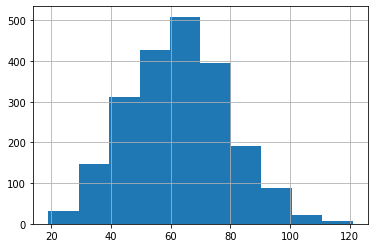

In [52]:
df.Date.value_counts().hist()

February 27, 2019, the day with the highest number of delays (106), was the day of heavy snow storms in Toronto, so it makes sense to expect a lot of delays on that day. May 22, 2016, the day with the lowest number of delays (17), was a Sunday. With less traffic and trains running less frequently, it is plausible that there are fewer delays. 

A lot of the delay times are rounded (i.e. turn of the hour, half-hour mark), but this should hopefully not affect the analysis too much since I don't plan to segment by anything more granular than hourly. 

In [53]:
df.Time.value_counts()

22:00    2085
23:30     582
06:00     453
11:30     370
19:30     320
23:00     291
19:00     269
08:00     258
05:55     251
09:00     228
12:00     219
23:15     218
05:40     209
05:45     201
08:40     199
11:00     193
08:33     190
23:20     190
19:45     189
22:30     187
08:30     185
08:32     184
08:51     184
08:35     183
08:56     182
08:20     180
08:50     179
08:47     179
08:45     176
08:13     176
         ... 
03:37       3
04:17       3
03:39       3
04:26       3
03:21       3
04:21       3
03:31       3
04:46       3
04:52       3
03:34       2
04:06       2
03:43       2
04:35       2
03:29       2
03:07       2
03:38       2
04:38       2
03:14       2
04:13       2
04:05       2
04:27       1
03:57       1
03:24       1
04:07       1
03:23       1
04:08       1
04:36       1
03:55       1
04:15       1
04:18       1
Name: Time, Length: 1437, dtype: int64

## Save Results

In [61]:
new_df.columns = [re.sub(' ', '_', x.lower()) for x in new_df.columns]
        
new_df[['date', 'time', 'weekday', 'hour',
        'line_cleaned', 'station_cleaned', 
        'code', 'desc', 'min_delay', 
        'indicator_ns', 'indicator_station']].to_csv('processed_data/ttc_subway_delay_data.csv', index = False)

# Get Historical Weather Data

One question I wanted to explore was if weather (i.e. heavy rain or snow) affects commute time. For this, I downloaded historical weather data from Environment Canada for 2014 - 2019. The daily data is available for download by year into csv format. 

In [58]:
years = [2014, 2015, 2016, 2017, 2018, 2019]

for year in years:
    
    url = f"https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=51459&Year={year}&timeframe=2&submit=Download+Data"
    fname = f"weather_data/daily_weather_{year}.csv"
    
    with requests.get(url, stream = True) as r:
        with open(fname, 'wb') as f:
            f.write(r.content)

In [59]:
weather = pd.DataFrame()

for year in years:
    
    fname = f"weather_data/daily_weather_{year}.csv"
    weather_i = pd.read_csv(fname)
    weather = weather.append(weather_i)
    os.remove(fname)

weather = weather.reset_index(drop = True)
weather.head()

,Longitude (x),Latitude (y),Station Name,Climate ID,Date/Time,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
0,-79.63,43.68,TORONTO INTL A,6158731,2014-01-01,2014,1,1,NaN,-10.0,...,0.0,NaN,0.0,NaN,3.0,NaN,27.0,NaN,35,NaN
1,-79.63,43.68,TORONTO INTL A,6158731,2014-01-02,2014,1,2,NaN,-15.2,...,1.0,NaN,0.8,NaN,3.0,NaN,35.0,NaN,48,NaN
2,-79.63,43.68,TORONTO INTL A,6158731,2014-01-03,2014,1,3,NaN,-9.2,...,0.0,NaN,0.0,NaN,4.0,NaN,21.0,NaN,41,NaN
3,-79.63,43.68,TORONTO INTL A,6158731,2014-01-04,2014,1,4,NaN,-0.4,...,0.4,NaN,0.4,NaN,4.0,NaN,23.0,NaN,57,NaN
4,-79.63,43.68,TORONTO INTL A,6158731,2014-01-05,2014,1,5,NaN,-0.1,...,11.6,NaN,14.4,NaN,6.0,NaN,NaN,NaN,<31,NaN


In [60]:
weather.to_csv('weather_data/daily_weather.csv', index = False)